 # Stroke Rehab Analysis

In [1]:
# 1. Configure plotting & imports
%matplotlib inline
import numpy as np
import mne
from scipy.io import loadmat
from matplotlib import pyplot as plt

# Ensure every new plot starts fresh
plt.close('all')


In [2]:
# 2. Load .mat and inspect
data = loadmat('/Dev/stroke-rehab-data-analysis/data/stroke-rehab/P3_post_training.mat')
print("Keys:", data.keys())

# extract
fs       = float(data['fs'].squeeze())
triggers = data['trig'].ravel()
raw_data = data['y'].T


Keys: dict_keys(['__header__', '__version__', '__globals__', 'fs', 'trig', 'y'])


In [3]:
channels = ['FC3','FCz','FC4','C5','C3','C1','Cz','C2','C4','C6',
            'CP3','CP1','CPz','CP2','CP4','Pz']
info = mne.create_info(ch_names=channels, sfreq=fs, ch_types=['eeg']*len(channels))
info.set_montage('standard_1020')      # optional, for topomaps

raw = mne.io.RawArray(raw_data, info)


Creating RawArray with float64 data, n_channels=16, n_times=206504
    Range : 0 ... 206503 =      0.000 ...   806.652 secs
Ready.


In [4]:
# clear old figures
plt.close('all')

# find onsets/durations from triggers
p = np.r_[0, triggers, 0]
d = np.diff(p)
idx = np.where(d != 0)[0]
onsets, offsets = idx[::2], idx[1::2]
vals = triggers[onsets]
times = onsets / fs
dur   = (offsets - onsets) / fs
desc  = ['left' if v==1 else 'right' for v in vals]

annots = mne.Annotations(onset=times, duration=dur, description=desc)
raw.set_annotations(annots)


<RawArray | 16 x 206504 (806.7 s), ~25.2 MiB, data loaded>

In [5]:
plt.close('all')

events, event_id = mne.events_from_annotations(raw,
                                               event_id={'left':1,'right':2})
# shift to cue at +2s
events[:, 0] += int(2 * fs)

epochs = mne.Epochs(raw, events, event_id=event_id,
                    tmin=-0.2, tmax=6.0, preload=True)


Used Annotations descriptions: [np.str_('left'), np.str_('right')]
Not setting metadata
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 80 events and 1588 original time points ...
0 bad epochs dropped


In [6]:
epochs.get_data().shape

(80, 16, 1588)

Computing rank from data with rank=None
    Using tolerance 54 (2.2e-16 eps * 6 dim * 4.1e+16  max singular value)
    Estimated rank (data): 6
    data: rank 6 computed from 6 data channels with 0 projectors
Reducing data rank from 6 -> 6
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=2 covariance using EMPIRICAL
Done.


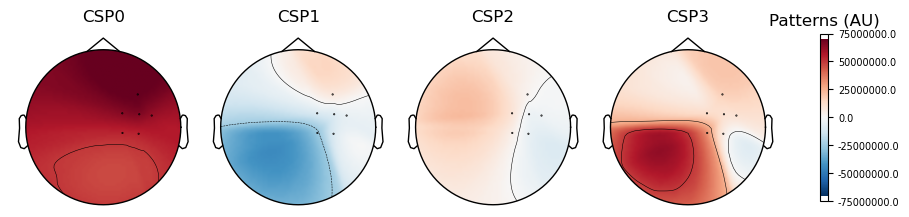

In [ ]:
from mne.decoding import CSP
csp = CSP(n_components=4, transform_into='csp_space')
labels = epochs.events[:, 2]
right_ch_epochs = epochs.copy().pick(('FC4', 'C6', 'C4', 'C2', 'CP4', 'CP2'))
X_csp_right = csp.fit_transform(right_ch_epochs.get_data(), labels)
plt.close('all')
fig = csp.plot_patterns(right_ch_epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)
plt.show(fig)


Computing rank from data with rank=None
    Using tolerance 51 (2.2e-16 eps * 6 dim * 3.9e+16  max singular value)
    Estimated rank (data): 6
    data: rank 6 computed from 6 data channels with 0 projectors
Reducing data rank from 6 -> 6
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=2 covariance using EMPIRICAL
Done.


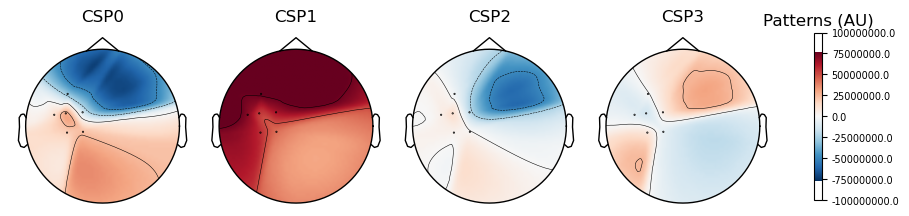

In [ ]:
from mne.decoding import CSP
csp = CSP(n_components=4, transform_into='csp_space')
labels = epochs.events[:, 2]
left_ch_epochs = epochs.copy().pick(('FC3', 'C5', 'C3', 'C1', 'CP3', 'CP1'))
X_csp_left = csp.fit_transform(left_ch_epochs.get_data(), labels)
plt.close('all')
fig = csp.plot_patterns(left_ch_epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)
plt.show(fig)


In [9]:
X_csp.shape

(80, 4, 1588)

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mne.decoding import CSP

component_range = [2, 4, 6, 8, 10]


# Assuming 'epochs' is your Epochs object and 'labels' are the corresponding labels
X = epochs.get_data()
y = labels

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
scores = []

for n in component_range:
    csp = CSP(n_components=n, reg=None, log=True, norm_trace=False)
    lda = LinearDiscriminantAnalysis()
    clf = Pipeline([('CSP', csp), ('LDA', lda)])
    cv_scores = cross_val_score(clf, X, y, cv=cv, n_jobs=1)
    mean_score = np.mean(cv_scores)
    scores.append(mean_score)
    print(f'n_components = {n}, Accuracy = {mean_score:.3f}')


In [ ]:
best_n = component_range[np.argmax(scores)]
print(f'Optimal number of components: {best_n}')


In [ ]:
csp = CSP(n_components=best_n, reg=None, log=True, norm_trace=False)
lda = LinearDiscriminantAnalysis()
clf = Pipeline([('CSP', csp), ('LDA', lda)])
clf.fit(X, y)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
)
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline

# 1. split into train & test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 2. rebuild & fit on training data
csp = CSP(n_components=best_n, reg=None, log=True, norm_trace=False)
lda = LinearDiscriminantAnalysis()
clf = Pipeline([('CSP', csp), ('LDA', lda)])
clf.fit(X_train, y_train)

# 3. predict on test set
y_pred = clf.predict(X_test)

# 4. classification report
print("Classification report on test set:\n")
print(classification_report(y_test, y_pred))

# 5. confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# 6. (if binary) ROC curve
if len(clf.classes_) == 2:
    # decision_function gives distance to hyperplane
    y_score = clf.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=clf.classes_[1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1], [0,1], 'k--', label='chance')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

# 7. visualize CSP patterns on full data
csp.fit(X, y)  # refit on everything
fig = csp.plot_patterns(
    epochs.info,
    ch_type='eeg',
    units='Patterns (AU)',
    size=1.5
)
plt.show(fig)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline

from mne import Epochs, pick_types
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf
epochs_train = epochs.copy()
labels = epochs.events[:, 2]

In [ ]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data(copy=False)
epochs_data_train = epochs_train.get_data(copy=False)
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}")

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

In [ ]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.close('all')
raw.plot(n_channels=4, scalings=1e2, block=True)


In [ ]:
raw.get_data().shape

In [ ]:
def add_arrows(axes):
    """Add some arrows at 60 Hz and its harmonics."""
    for ax in axes:
        freqs = ax.lines[-1].get_xdata()
        psds = ax.lines[-1].get_ydata()
        for freq in (60, 120, 180, 240):
            idx = np.searchsorted(freqs, freq)
            # get ymax of a small region around the freq. of interest
            y = psds[(idx - 4) : (idx + 5)].max()
            ax.arrow(
                x=freqs[idx],
                y=y + 18,
                dx=0,
                dy=-12,
                color="red",
                width=0.1,
                head_width=3,
                length_includes_head=True,
            )

In [ ]:
plt.close('all')
spectrum = raw.compute_psd()
fig = spectrum.plot(average=True, amplitude=False)
plt.show(fig)


In [ ]:
plt.close('all')
fig = raw.compute_psd().plot(dB=True)
plt.show(fig)

In [ ]:
plt.close('all')
fig = epochs.plot(n_epochs=15, scalings='auto', block=True)
plt.show(fig)

In [ ]:
plt.close('all')
bands = {'Alpha':(8,12), 'Beta':(12,30)}
fig = epochs.compute_psd().plot_topomap(bands=bands)
plt.show(fig)


In [ ]:
plt.close('all')
epochs.plot_image(picks='C3', combine='mean', sigma=1.0)


In [ ]:
plt.close('all')
epochs.plot_image(picks='Cz', combine='mean', sigma=1.0)


In [ ]:
plt.close('all')
epochs.plot_image(picks='C4', combine='mean', sigma=1.0)


# Filter data

In [ ]:

raw_1_40 = raw.copy().filter(l_freq=1, h_freq=40.)
raw_0_7 = raw.copy().filter(l_freq=0.5, h_freq=7.)


In [ ]:
plt.close('all')
fig = raw_1_40.compute_psd().plot(average=True, picks="data", exclude="bads", amplitude=False)
plt.show(fig)
plt.close('all')
fig = raw.compute_psd().plot(average=True, picks="data", exclude="bads", amplitude=False)
plt.show(fig)

In [ ]:
plt.close('all')
fig = raw_0_7.compute_psd().plot(average=True, picks="data", exclude="bads", amplitude=False)
plt.show(fig)